In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy.stats import ttest_ind, norm


file_path = '../data/sirs_demo_abc_clean'
df = pd.read_pickle(file_path)

In [2]:
df['Date Reviewed'] = pd.to_datetime(df['Date Reviewed'], errors='coerce')

df = df.dropna(subset=['Date Reviewed'])

df['sum_abc'] = df[['Irritability/Agitation', 'Lethargy/Social Withdrawal', 'Stereotypic Behavior',
                   'Hyperactivity/Noncompliance', 'Inappropriate Speech']].sum(axis=1)

# COVID-19 onset date based on when the United States declated a national emergency
covid_onset_date = pd.Timestamp('2020-03-13')
# List of races to analyze
races = df['race_clean'].unique()

In [3]:
before_covid_data = df[df['Date Reviewed'] < covid_onset_date]
after_covid_data = df[df['Date Reviewed'] >= covid_onset_date]

before_covid_intake = before_covid_data[before_covid_data['Type of Service'] == 'Intake']
before_covid_reevaluation = before_covid_data[before_covid_data['Type of Service'] == 'Re-evaluation']

after_covid_intake = after_covid_data[after_covid_data['Type of Service'] == 'Intake']
after_covid_reevaluation = after_covid_data[after_covid_data['Type of Service'] == 'Re-evaluation']

In [4]:
pre_observations = before_covid_data.shape[0]
pre_intake_observations = before_covid_intake.shape[0]
pre_reeval_observations = before_covid_reevaluation.shape[0]

post_observations = after_covid_data.shape[0]
post_intake_observations = after_covid_intake.shape[0]
post_reeval_observations = after_covid_reevaluation.shape[0]


In [5]:
# Get the breakdown of counts by race
race_counts_pre_intake = before_covid_intake['race_clean'].value_counts()
race_counts_pre_reevaluation = before_covid_reevaluation['race_clean'].value_counts()
race_counts_post_intake = after_covid_intake['race_clean'].value_counts()
race_counts_post_reevaluation = after_covid_reevaluation['race_clean'].value_counts()

# combine in a dataframe
descriptive_analysis = pd.DataFrame({
    'Testing Window': ['Pre-COVID', 'Post-COVID'],
    'Intake': [pre_intake_observations, post_intake_observations],
    'Re-evaluation' : [pre_reeval_observations, post_reeval_observations],
    'Total': [pre_observations, post_observations]
})

# stylize the table
styled_total = descriptive_analysis.style.hide(axis='index').set_caption("Pre- and Post-COVID Observations")\
    .format(na_rep='-', precision=0)\
    .set_table_styles(
        [{'selector': 'caption',
          'props': [('color', 'black'),
                    ('font-size', '16px'),
                    ('text-align', 'center'),
                    ('font-weight', 'bold')]},
         {'selector': 'th',
          'props': [('border', '1px solid black'),
                    ('background-color', '#f7f7f7'),
                    ('padding', '5px')]},
         {'selector': 'td',
          'props': [('border', '1px solid black'),
                    ('padding', '5px')]}]
    )

styled_total

Testing Window,Intake,Re-evaluation,Total
Pre-COVID,4069,8795,12941
Post-COVID,907,5561,6484


In [6]:
# adjust dfs to add to a race df
race_counts_pre_intake_df = race_counts_pre_intake.reset_index()
race_counts_pre_intake_df.columns = ['Race', 'Pre-COVID Intake']

race_counts_pre_reevaluation_df = race_counts_pre_reevaluation.reset_index()
race_counts_pre_reevaluation_df.columns = ['Race', 'Pre-COVID Re-evaluation']

race_counts_post_intake_df = race_counts_post_intake.reset_index()
race_counts_post_intake_df.columns = ['Race', 'Post-COVID Intake']

race_counts_post_reevaluation_df = race_counts_post_reevaluation.reset_index()
race_counts_post_reevaluation_df.columns = ['Race', 'Post-COVID Re-evaluation']

# Merge into a single dataframe
race_counts_merged = pd.merge(race_counts_pre_intake_df, race_counts_pre_reevaluation_df, on='Race', how='outer')
race_counts_merged = pd.merge(race_counts_merged, race_counts_post_intake_df, on='Race', how='outer')
race_counts_merged = pd.merge(race_counts_merged, race_counts_post_reevaluation_df, on='Race', how='outer')

# remove NA values
race_counts_merged.fillna(0, inplace=True)


# Reorder columns
race_counts_merged = race_counts_merged[['Race', 'Pre-COVID Intake', 'Pre-COVID Re-evaluation', 'Post-COVID Intake', 'Post-COVID Re-evaluation']]


# Stylize the df
styled_table = race_counts_merged.style.hide(axis="index").set_caption("Count of Pre- and Post-COVID Observations by Race")\
    .format(na_rep='-', precision=0)\
    .set_table_styles(
        [{'selector': 'caption',
          'props': [('color', 'black'),
                    ('font-size', '16px'),
                    ('text-align', 'center'),
                    ('font-weight', 'bold')]},
         {'selector': 'th',
          'props': [('border', '1px solid black'),
                    ('background-color', '#f7f7f7'),
                    ('padding', '5px')]},
         {'selector': 'td',
          'props': [('border', '1px solid black'),
                    ('padding', '5px')]}]
    )

styled_table

Race,Pre-COVID Intake,Pre-COVID Re-evaluation,Post-COVID Intake,Post-COVID Re-evaluation
White,2492,5610,586,3444
Black/African American,857,2005,159,1092
Other/Unknown,360,546,83,467
Hispanic/Latinx,200,353,43,336
Asian/Pacific Islander,139,242,30,183
American Indian or Alaska Native,21,39,6,39


In [9]:
# Function to analyze differences by race
def analyze_by_race(race):    
    # Further separate into Intake and Re-evaluation for both periods
    before_covid_intake_race = before_covid_intake[before_covid_intake['race_clean'] == race]
    before_covid_reevaluation_race = before_covid_reevaluation[before_covid_reevaluation['race_clean'] == race]

    after_covid_intake_race = after_covid_intake[after_covid_intake['race_clean'] == race]
    after_covid_reevaluation_race = after_covid_reevaluation[after_covid_reevaluation['race_clean'] == race]

    # Calculate  mean scores for each behavior at Intake and Re-evaluation for both periods
    before_covid_intake_means = before_covid_intake_race.mean(numeric_only=True)
    before_covid_reevaluation_means = before_covid_reevaluation_race.mean(numeric_only=True)

    after_covid_intake_means = after_covid_intake_race.mean(numeric_only=True)
    after_covid_reevaluation_means = after_covid_reevaluation_race.mean(numeric_only=True)

    # Combine the means into dfs for comparison
    before_covid_comparison = pd.DataFrame({
        'Intake Mean (Before COVID)': before_covid_intake_means,
        'Re-evaluation Mean (Before COVID)': before_covid_reevaluation_means
    })
    before_covid_comparison['Percent Change (Before COVID)'] = (before_covid_comparison['Re-evaluation Mean (Before COVID)'] - before_covid_comparison['Intake Mean (Before COVID)']) / before_covid_comparison['Intake Mean (Before COVID)'] * 100

    after_covid_comparison = pd.DataFrame({
        'Intake Mean (After COVID)': after_covid_intake_means,
        'Re-evaluation Mean (After COVID)': after_covid_reevaluation_means
    })
    after_covid_comparison['Percent Change (After COVID)'] = (after_covid_comparison['Re-evaluation Mean (After COVID)'] - after_covid_comparison['Intake Mean (After COVID)']) / after_covid_comparison['Intake Mean (After COVID)'] * 100

    # Calculate change in percent change
    change_in_difference = before_covid_comparison['Percent Change (Before COVID)'] - after_covid_comparison['Percent Change (After COVID)']
    change_in_difference.name = 'Change in Percent Change'

    return change_in_difference


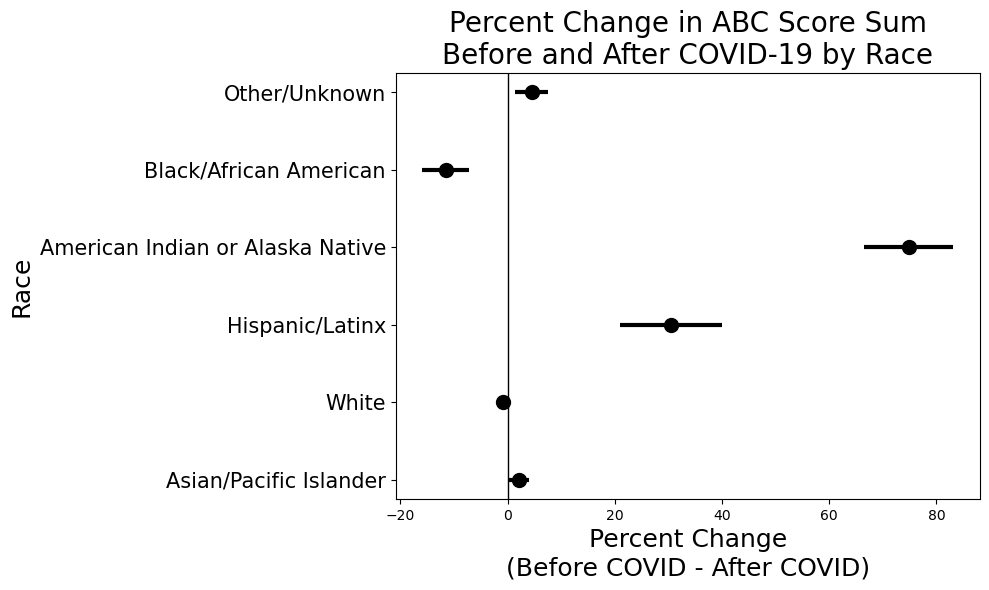

In [10]:
# analyze differences by race and calculate confidence intervals
def analyze_and_calculate_ci_by_race(race):
    change_in_difference = analyze_by_race(race)
    sum_change_in_difference = change_in_difference.sum()

    std_err = stats.sem(change_in_difference)
    
    test_stat = sum_change_in_difference / std_err
    
    p_value = 2 * (1 - stats.t.cdf(abs(test_stat), df=len(change_in_difference) - 1))

    z_score = stats.norm.ppf(1 - p_value / 2)

    margin_of_error = z_score * std_err

    return sum_change_in_difference, margin_of_error

sum_changes_ci_by_race = {race: analyze_and_calculate_ci_by_race(race) for race in races}

sum_changes_df = pd.DataFrame(sum_changes_ci_by_race, index=['Sum of Changes', 'CI']).T

# Adjust the scale of the objects in the plot
line_width = 3  
marker_size = 10  
label_font_size = 18
title_font_size = 20
tick_font_size = 15

plt.figure(figsize=(10, 6))

for i, race in enumerate(sum_changes_df.index):
    plt.errorbar(sum_changes_df.loc[race, 'Sum of Changes'], i, xerr=sum_changes_df.loc[race, 'CI'], fmt='o', color='black', capsize=0, linewidth=line_width, markersize=marker_size)

plt.axvline(0, color='black', linewidth=1, linestyle='-')

plt.xlabel('Percent Change\n(Before COVID - After COVID)', fontsize=label_font_size)
plt.ylabel('Race', fontsize=label_font_size)
plt.title('Percent Change in ABC Score Sum\nBefore and After COVID-19 by Race', fontsize=title_font_size)
plt.yticks(range(len(sum_changes_df.index)), sum_changes_df.index, fontsize=tick_font_size)

plt.tight_layout()

plt.savefig('../output/change_in_abc_score_by_race.png')

plt.show()

In [11]:
numeric_columns = df.select_dtypes(include=['number']).columns


# Function to analyze differences by race and calculate p-values
def analyze_and_calculate_p_value_by_race(race):
    change_in_difference = analyze_by_race(race)

    sum_change_in_difference = change_in_difference.sum()

    std_err = stats.sem(change_in_difference)
    
    test_stat = sum_change_in_difference / std_err
    
    p_value = 2 * (1 - stats.t.cdf(abs(test_stat), df=len(change_in_difference) - 1))

    return sum_change_in_difference, p_value



sum_changes_p_values_by_race = {race: analyze_and_calculate_p_value_by_race(race) for race in races}

sum_changes_df = pd.DataFrame(sum_changes_p_values_by_race, index=['Percent Change', 'p-value']).T

sum_changes_df['Statistical Significance'] = sum_changes_df['p-value'].apply(lambda p: 'Significant' if p < 0.05 else 'Not Significant')

sum_changes_df

,Percent Change,p-value,Statistical Significance
Asian/Pacific Islander,2.048175,4.442141e-01,Not Significant
White,-0.780036,3.725839e-01,Not Significant
Hispanic/Latinx,30.470324,4.595358e-05,Significant
American Indian or Alaska Native,74.840653,7.087598e-08,Significant
Black/African American,-11.581669,1.698201e-04,Significant
Other/Unknown,4.462675,2.205497e-02,Significant


In [12]:
def diff_means(race, column):
    # Separate data into before and after COVID-19 windows
    before_covid_data_race = before_covid_data[before_covid_data['race_clean'] == race]
    after_covid_data_race = after_covid_data[after_covid_data['race_clean'] == race]

    # run t-test 
    ttest_results = {}
    t_stat, p_value = ttest_ind(before_covid_data_race[column].dropna(), after_covid_data_race[column].dropna())
    ttest_results[column] = {'t_stat': t_stat, 'p_value': p_value}

    return pd.DataFrame(ttest_results).T

diff_means("White", column = "sum_abc")

,p_value,t_stat
sum_abc,2.377312e-10,6.340093


In [13]:
def diff_means(race, column):
    # Separate data into before and after COVID-19 windows
    before_covid_data_race = before_covid_data[before_covid_data['race_clean'] == race]
    after_covid_data_race = after_covid_data[after_covid_data['race_clean'] == race]

    # Means
    mean_before = before_covid_data_race[column].mean()
    mean_after = after_covid_data_race[column].mean()

    # Difference in means
    mean_diff = mean_after - mean_before

    # t-test
    t_stat, p_value = ttest_ind(before_covid_data_race[column].dropna(), after_covid_data_race[column].dropna())

    # Confidence interval
    n1 = before_covid_data_race[column].dropna().shape[0]
    n2 = after_covid_data_race[column].dropna().shape[0]
    std_before = before_covid_data_race[column].dropna().std()
    std_after = after_covid_data_race[column].dropna().std()
    se = np.sqrt(std_before**2 / n1 + std_after**2 / n2)
    confidence_level = 0.95
    z = norm.ppf(1 - (1 - confidence_level) / 2)
    ci_lower = mean_diff - z * se
    ci_upper = mean_diff + z * se

    results = pd.DataFrame({
        'mean_before': [mean_before],
        'mean_after': [mean_after],
        'mean_diff': [mean_diff],
        't_stat': [t_stat],
        'p_value': [p_value],
        'ci_lower': [ci_lower],
        'ci_upper': [ci_upper]
    }, index=[column])

    return results

# Test run
result = diff_means("White", column="sum_abc")
print(result)



# Analysis for each race and combine the results
all_results = []
for race in races:
    result = diff_means(race, column="sum_abc")
    result['race'] = race  # Add the race information to the results
    all_results.append(result)

# Combine all results into a single DataFrame
combined_results = pd.concat(all_results, ignore_index=True)

print(combined_results)

         mean_before  mean_after  mean_diff    t_stat       p_value  ci_lower  \
sum_abc    54.645861   50.957663  -3.688199  6.340093  2.377312e-10 -4.821425   

         ci_upper  
sum_abc -2.554973  
   mean_before  mean_after  mean_diff    t_stat       p_value   ci_lower  \
0    60.664042   53.336449  -7.327593  2.781692  5.579630e-03 -12.523528   
1    54.645861   50.957663  -3.688199  6.340093  2.377312e-10  -4.821425   
2    63.101266   51.346457 -11.754809  5.327125  1.251462e-07 -16.084124   
3    62.590164   59.888889  -2.701275  0.500998  6.174311e-01 -13.014519   
4    54.844738   51.388048  -3.456690  3.313429  9.295287e-04  -5.429791   
5    60.020833   53.930909  -6.089924  3.555666  3.890566e-04  -9.468419   

   ci_upper                              race  
0 -2.131659            Asian/Pacific Islander  
1 -2.554973                             White  
2 -7.425495                   Hispanic/Latinx  
3  7.611968  American Indian or Alaska Native  
4 -1.483589            B

In [12]:
def diff_means_service(race, column):
    # Filter data by race and period
    before_covid_intake_race = before_covid_intake[before_covid_intake['race_clean'] == race]
    before_covid_reevaluation_race = before_covid_reevaluation[before_covid_reevaluation['race_clean'] == race]

    after_covid_intake_race = after_covid_intake[after_covid_intake['race_clean'] == race]
    after_covid_reevaluation_race = after_covid_reevaluation[after_covid_reevaluation['race_clean'] == race]

    # Calculate the mean scores for each behavior at Intake and Re-evaluation for both periods
    before_covid_intake_means = before_covid_intake_race.mean(numeric_only=True)
    before_covid_reevaluation_means = before_covid_reevaluation_race.mean(numeric_only=True)

    after_covid_intake_means = after_covid_intake_race.mean(numeric_only=True)
    after_covid_reevaluation_means = after_covid_reevaluation_race.mean(numeric_only=True)
    
    # Calculate the difference in means
    mean_diff_before = before_covid_intake_means - before_covid_reevaluation_means
    mean_diff_after = after_covid_intake_means - after_covid_reevaluation_means

    # Perform t-test for before COVID-19
    t_stat_before, p_value_before = ttest_ind(
        before_covid_intake_race[column].dropna(),
        before_covid_reevaluation_race[column].dropna()
    )

    # Perform t-test for after COVID-19
    t_stat_after, p_value_after = ttest_ind(
        after_covid_intake_race[column].dropna(),
        after_covid_reevaluation_race[column].dropna()
    )

    # Calculate the confidence interval for before COVID-19
    n1_before = before_covid_intake_race[column].dropna().shape[0]
    n2_before = before_covid_reevaluation_race[column].dropna().shape[0]
    std_before_before = before_covid_intake_race[column].dropna().std()
    std_after_before = before_covid_reevaluation_race[column].dropna().std()
    se_before = np.sqrt(std_before_before**2 / n1_before + std_after_before**2 / n2_before)
    confidence_level = 0.95
    z = norm.ppf(1 - (1 - confidence_level) / 2)
    ci_lower_before = mean_diff_before - z * se_before
    ci_upper_before = mean_diff_before + z * se_before

    # Calculate the confidence interval for after COVID-19
    n1_after = after_covid_intake_race[column].dropna().shape[0]
    n2_after = after_covid_reevaluation_race[column].dropna().shape[0]
    std_before_after = after_covid_intake_race[column].dropna().std()
    std_after_after = after_covid_reevaluation_race[column].dropna().std()
    se_after = np.sqrt(std_before_after**2 / n1_after + std_after_after**2 / n2_after)
    ci_lower_after = mean_diff_after - z * se_after
    ci_upper_after = mean_diff_after + z * se_after

    # Calculate the change in difference
    change_in_difference = mean_diff_before - mean_diff_after

    # Perform t-test for change in difference
    t_stat_change, p_value_change = ttest_ind(
        before_covid_data[before_covid_data['Type of Service'] == 'Intake'][column].dropna(),
        after_covid_data[after_covid_data['Type of Service'] == 'Re-evaluation'][column].dropna()
    )

    # Store results in a DataFrame
    results = pd.DataFrame({
        'mean_before_intake': [before_covid_intake_means[column]],
        'mean_before_reevaluation': [before_covid_reevaluation_means[column]],
        'mean_after_intake': [after_covid_intake_means[column]],
        'mean_after_reevaluation': [after_covid_reevaluation_means[column]],
        'mean_diff_before': [mean_diff_before[column]],
        'mean_diff_after': [mean_diff_after[column]],
        't_stat_change': [t_stat_change],
        'p_value_change': [p_value_change],
        'ci_lower_before': [ci_lower_before[column]],
        'ci_upper_before': [ci_upper_before[column]],
        'ci_lower_after': [ci_lower_after[column]],
        'ci_upper_after': [ci_upper_after[column]],
        'change_in_difference': [change_in_difference[column]]
    })

    return results


# Perform analysis for each race and combine the results
all_results = []
for race in races:
    result = diff_means_service(race, column="sum_abc")
    result['race'] = race  # Add the race information to the results
    all_results.append(result)

# Concatenate all results into a single DataFrame
df_comb = pd.concat(all_results, ignore_index=True)

df_comb

,mean_before_intake,mean_before_reevaluation,mean_after_intake,mean_after_reevaluation,mean_diff_before,mean_diff_after,t_stat_change,p_value_change,ci_lower_before,ci_upper_before,ci_lower_after,ci_upper_after,change_in_difference,race
0,72.071942,54.111570,65.633333,51.234973,17.960372,14.398361,28.423672,1.009002e-170,11.724575,24.196170,1.560635,27.236086,3.562012,Asian/Pacific Islander
1,66.181782,49.680927,64.587031,48.624564,16.500855,15.962466,28.423672,1.009002e-170,15.080355,17.921355,13.336129,18.588803,0.538389,White
2,72.145000,57.977337,64.348837,49.473214,14.167663,14.875623,28.423672,1.009002e-170,8.347949,19.987377,4.802824,24.948422,-0.707960,Hispanic/Latinx
3,67.142857,61.256410,72.333333,57.974359,5.886447,14.358974,28.423672,1.009002e-170,-8.862447,20.635341,-6.069118,34.787067,-8.472527,American Indian or Alaska Native
4,66.324387,50.040399,63.358491,49.703297,16.283988,13.655194,28.423672,1.009002e-170,13.784659,18.783317,8.682540,18.627848,2.628795,Black/African American
5,69.300000,54.170330,67.590361,51.503212,15.129670,16.087149,28.423672,1.009002e-170,11.023892,19.235449,8.051134,24.123165,-0.957479,Other/Unknown


In [13]:
combined_results

,mean_before,mean_after,mean_diff,t_stat,p_value,ci_lower,ci_upper,race
0,60.664042,53.336449,-7.327593,2.781692,5.579630e-03,-12.523528,-2.131659,Asian/Pacific Islander
1,54.645861,50.957663,-3.688199,6.340093,2.377312e-10,-4.821425,-2.554973,White
2,63.101266,51.346457,-11.754809,5.327125,1.251462e-07,-16.084124,-7.425495,Hispanic/Latinx
3,62.590164,59.888889,-2.701275,0.500998,6.174311e-01,-13.014519,7.611968,American Indian or Alaska Native
4,54.844738,51.388048,-3.456690,3.313429,9.295287e-04,-5.429791,-1.483589,Black/African American
5,60.020833,53.930909,-6.089924,3.555666,3.890566e-04,-9.468419,-2.711429,Other/Unknown


In [14]:
# Filter numeric columns (assuming that the first three columns are non-numeric)
numeric_columns = df.select_dtypes(include=['number']).columns

# Define the COVID-19 onset date
covid_onset_date = pd.Timestamp('2020-03-01')

# Ensure 'Date Reviewed' column is in datetime format
df['Date Reviewed'] = pd.to_datetime(df['Date Reviewed'], errors='coerce')

# Function to analyze differences by race and calculate confidence intervals
def before_covid_calc_race(race):
        # Further separate into Intake and Re-evaluation for both periods
    before_covid_intake_race = before_covid_intake[before_covid_intake['race_clean'] == race]
    before_covid_reevaluation_race = before_covid_reevaluation[before_covid_reevaluation['race_clean'] == race]

    after_covid_intake_race = after_covid_intake[after_covid_intake['race_clean'] == race]
    after_covid_reevaluation_race = after_covid_reevaluation[after_covid_reevaluation['race_clean'] == race]

    # Calculate the mean scores for each behavior at Intake and Re-evaluation for both periods
    before_covid_intake_means = before_covid_intake_race.mean(numeric_only=True)
    before_covid_reevaluation_means = before_covid_reevaluation_race.mean(numeric_only=True)

    after_covid_intake_means = after_covid_intake_race.mean(numeric_only=True)
    after_covid_reevaluation_means = after_covid_reevaluation_race.mean(numeric_only=True)

    # Combine the means into DataFrames for comparison
    before_covid_comparison = pd.DataFrame({
        'Intake Mean (Before COVID)': before_covid_intake_means,
        'Re-evaluation Mean (Before COVID)': before_covid_reevaluation_means
    })
    before_covid_comparison['Difference (Before COVID)'] = before_covid_comparison['Intake Mean (Before COVID)'] - before_covid_comparison['Re-evaluation Mean (Before COVID)']

    return before_covid_comparison
    
    # after_covid_comparison = pd.DataFrame({
    #     'Intake Mean (After COVID)': after_covid_intake_means,
    #     'Re-evaluation Mean (After COVID)': after_covid_reevaluation_means
    # })
    # after_covid_comparison['Difference (After COVID)'] = after_covid_comparison['Intake Mean (After COVID)'] - after_covid_comparison['Re-evaluation Mean (After COVID)']


In [15]:
before_covid_calc_race("Asian/Pacific Islander")

,Intake Mean (Before COVID),Re-evaluation Mean (Before COVID),Difference (Before COVID)
Irritability/Agitation,22.201439,15.747934,6.453505
Lethargy/Social Withdrawal,14.964029,11.900826,3.063202
Stereotypic Behavior,6.467626,5.128099,1.339527
Hyperactivity/Noncompliance,23.733813,17.690083,6.043730
Inappropriate Speech,4.705036,3.644628,1.060408
sum_abc,72.071942,54.111570,17.960372


In [16]:
# Convert date columns to datetime
df['Date Enrolled in START'] = pd.to_datetime(df['Date Enrolled in START'])

# Define the pandemic start date
pandemic_start_date = pd.Timestamp('2020-03-13')

# Segregate the data
df_before_pandemic = df[df['Date Enrolled in START'] < pandemic_start_date]
df_after_pandemic = df[df['Date Enrolled in START'] >= pandemic_start_date]

# Calculate count of enrollments by race before and after the pandemic
race_counts_before = df_before_pandemic['race_clean'].value_counts(normalize=True) * 100
race_counts_after = df_after_pandemic['race_clean'].value_counts(normalize=True) * 100

# Create a DataFrame to compare the counts
comparison_df = pd.DataFrame({
    'Before Pandemic (%)': race_counts_before,
    'After Pandemic (%)': race_counts_after
}).fillna(0)

comparison_df

,Before Pandemic (%),After Pandemic (%)
race_clean,,
White,62.737364,63.170441
Black/African American,21.637460,17.520858
Other/Unknown,7.387164,8.998808
Hispanic/Latinx,4.671212,6.257449
Asian/Pacific Islander,3.059672,3.098927
American Indian or Alaska Native,0.507128,0.953516


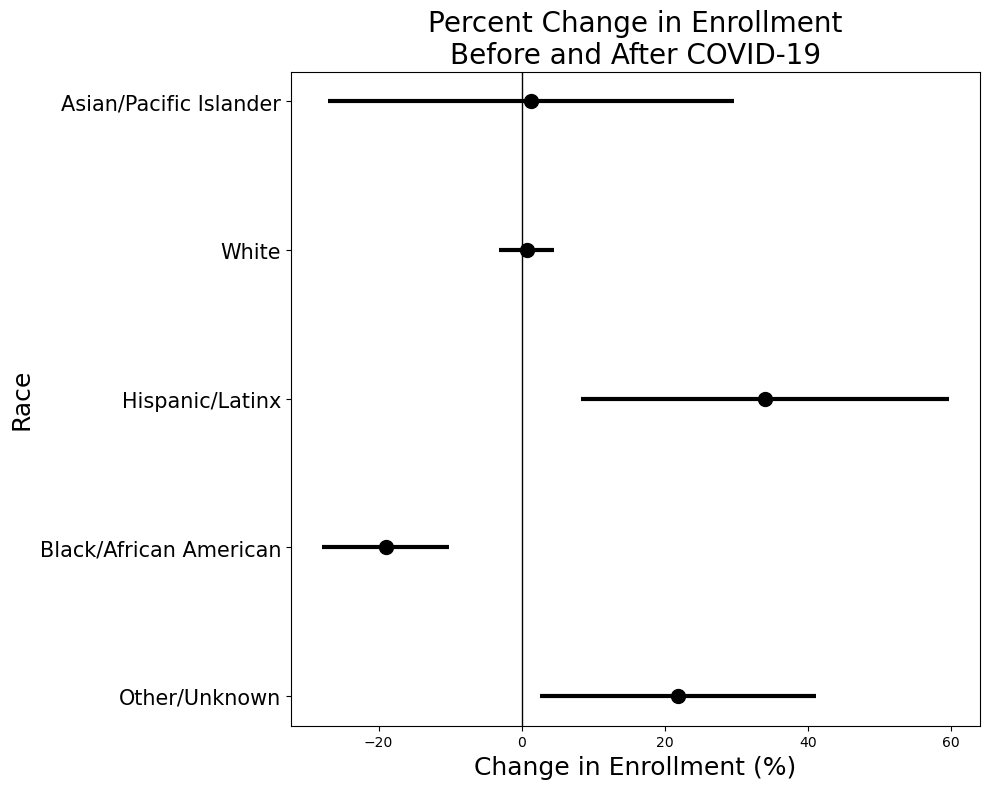

In [17]:
# Order the races
race_order = ['Asian/Pacific Islander', 'White', 'Hispanic/Latinx', 'Black/African American', 'Other/Unknown']

comparison_df = comparison_df.reindex(race_order)

comparison_df['Percent Change (%)'] = ((comparison_df['After Pandemic (%)'] - comparison_df['Before Pandemic (%)']) / comparison_df['Before Pandemic (%)']) * 100

comparison_df['Std Error Before'] = np.sqrt((comparison_df['Before Pandemic (%)'] * (100 - comparison_df['Before Pandemic (%)'])) / len(df_before_pandemic))
comparison_df['Std Error After'] = np.sqrt((comparison_df['After Pandemic (%)'] * (100 - comparison_df['After Pandemic (%)'])) / len(df_after_pandemic))

comparison_df['Std Error'] = (np.sqrt(comparison_df['Std Error Before']**2 + comparison_df['Std Error After']**2) / (comparison_df['Before Pandemic (%)'])) * 100

z_score = 1.96  # z-score for 95% confidence

comparison_df['95% CI Lower'] = comparison_df['Percent Change (%)'] - z_score * comparison_df['Std Error']
comparison_df['95% CI Upper'] = comparison_df['Percent Change (%)'] + z_score * comparison_df['Std Error']

# Style Settings
line_width = 3
marker_size = 10
label_font_size = 18
title_font_size = 20
tick_font_size = 15

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(comparison_df['Percent Change (%)'], comparison_df.index, 'o', color='black', markersize=marker_size)

for i in range(len(comparison_df)):
    ax.hlines(y=i, xmin=comparison_df['95% CI Lower'].iloc[i], xmax=comparison_df['95% CI Upper'].iloc[i], 
              color='black', linewidth=line_width)  

ax.axvline(x=0, linestyle='-', color='black', linewidth=1)  # Solid line as in the second plot

ax.set_xlabel('Change in Enrollment (%)', fontsize=label_font_size)
ax.set_ylabel('Race', fontsize=label_font_size)
ax.set_title('Percent Change in Enrollment\nBefore and After COVID-19', fontsize=title_font_size)

ax.set_yticks(range(len(comparison_df.index)))
ax.set_yticklabels(comparison_df.index, fontsize=tick_font_size)

ax.invert_yaxis()

plt.tight_layout()

plt.savefig('../output/change_in_enrollment_by_race.png')

plt.show()

In [18]:
## Calculate signifiacne of findings ##
sum_changes_p_values_by_race = {race: analyze_and_calculate_p_value_by_race(race) for race in races}

sum_changes_df = pd.DataFrame(sum_changes_p_values_by_race, index=['Percent Change', 'p-value']).T

sum_changes_df['Statistical Significance'] = sum_changes_df['p-value'].apply(lambda p: 'Significant' if p < 0.05 else 'Not Significant')

pd.set_option('display.float_format', lambda x: '%.6f' % x)

sum_changes_df

,Percent Change,p-value,Statistical Significance
Asian/Pacific Islander,2.048175,0.444214,Not Significant
White,-0.780036,0.372584,Not Significant
Hispanic/Latinx,30.470324,0.000046,Significant
American Indian or Alaska Native,74.840653,0.000000,Significant
Black/African American,-11.581669,0.000170,Significant
Other/Unknown,4.462675,0.022055,Significant
